<a href="https://colab.research.google.com/github/gabrielfea/previsaoacoes/blob/main/analise_acoes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pmdarima
!pip install tensorflow
!pip install keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn import metrics
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from sklearn import preprocessing

from pmdarima import auto_arima

import yfinance as yf
yf.pdr_override()

from pandas_datareader import data as pdr

import datetime
from datetime import date
from datetime import timedelta

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import plotly.figure_factory as ff
import plotly.offline as py
from plotly.subplots import make_subplots

from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten,TimeDistributed,RepeatVector
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPool1D
from tensorflow.keras.layers import Dropout

tf.random.set_seed(123)
np.random.seed(123)
import random
random.seed(123)

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


# Análise de Ação B3

In [3]:
def get(tickers,startdate,enddate):
   def data(ticker):
       return(pdr.get_data_yahoo(ticker, start=startdate,end=enddate))
   datas = map(data,tickers)
   all_data = pd.concat(datas, keys=tickers, names=['Ticker', 'Date'])
   return all_data

In [4]:
tickers = ["MGLU3.SA", "PETR3.SA", "PETR4.SA", "ITUB4.SA", "BOVA11.SA"]
startdate = date(2000,1,1)
enddate = date.today()

data = get(tickers,startdate,enddate)

asset = "MGLU3.SA"
data.loc[asset].tail()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-02-08,2.05,2.10,1.97,2.07,2.07,154722500
2024-02-09,2.07,2.14,2.05,2.08,2.08,164832500
2024-02-14,2.06,2.09,2.01,2.02,2.02,94878900
2024-02-15,2.02,2.08,1.98,2.06,2.06,191224400
2024-02-16,2.07,2.09,2.02,2.04,2.04,109874700


## Estatísticas Descritivas

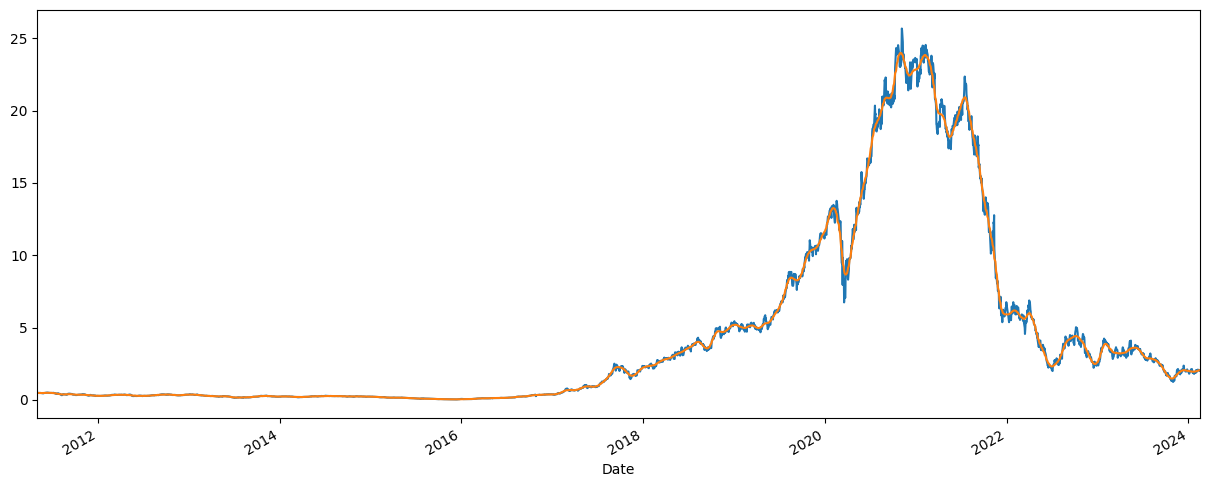

In [5]:
df = data.loc[asset,["Close","High","Low"]]
df_cycle,df_trend = hpfilter(df["Close"], lamb=1600)
df["Close"].plot(figsize=(15,6)).autoscale(axis='x',tight=True)
df_trend.plot(figsize=(15,6)).autoscale(axis='x',tight=True)
df["Trend"] = df_trend
df_close = df["Close"]

<Axes: >

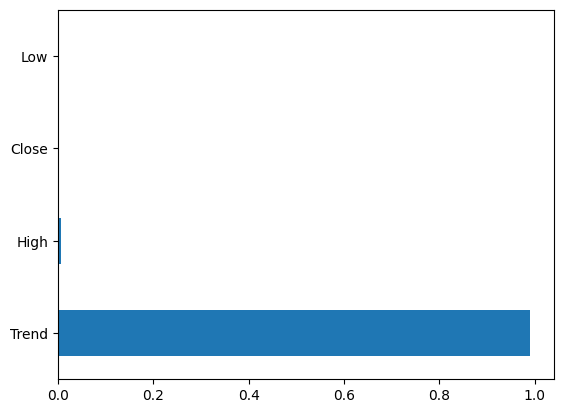

In [6]:
from numpy import loadtxt
from xgboost import XGBRegressor
from matplotlib import pyplot

model = XGBRegressor()
model.fit(df[["High","Low",'Close','Trend']],df['Trend'])

(pd.Series(model.feature_importances_, index=df[["High","Low",'Close','Trend']].columns)
   .nlargest(7)
   .plot(kind='barh'))

In [7]:
tamanho = len(df["Close"])

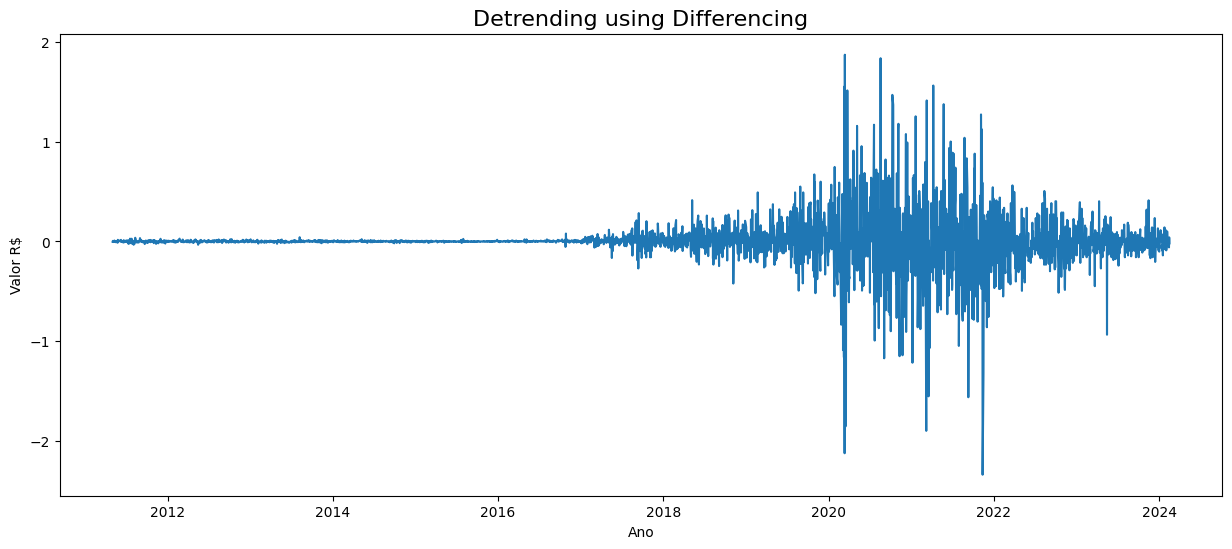

In [8]:
diff = df["Close"].diff()
plt.figure(figsize=(15,6))
plt.plot(diff)
plt.title('Detrending using Differencing', fontsize=16)
plt.xlabel('Ano')
plt.ylabel('Valor R$')
plt.show()

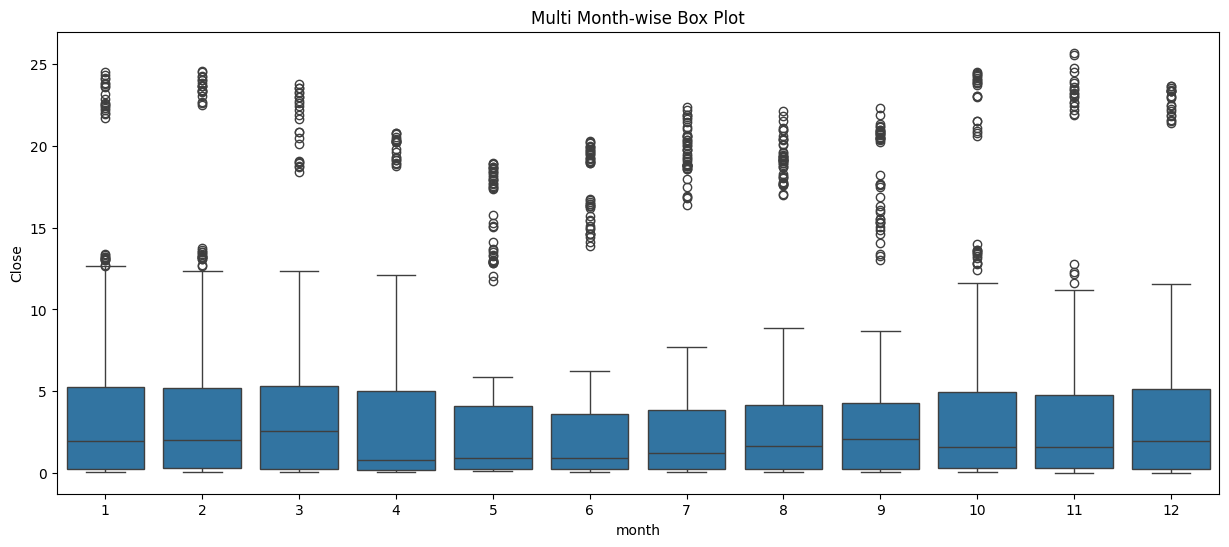

In [9]:
df2 = pd.DataFrame(df["Close"])
df2['Date'] = pd.to_datetime(df2.index)
df2['month'] = df2['Date'].dt.strftime('%b')
df2['year'] = [d.year for d in df2.Date]
df2['month'] = [d.month for d in df2.Date]
years = df2['year'].unique()
plt.figure(figsize=(15,6))
sns.boxplot(x='month', y="Close", data=df2).set_title("Multi Month-wise Box Plot")
plt.show()

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

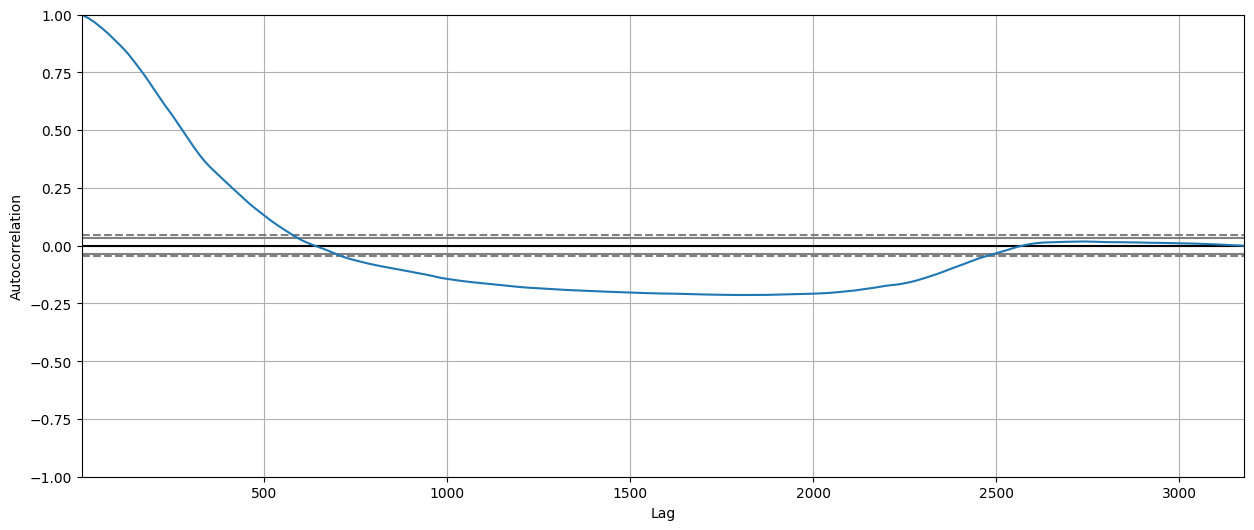

In [10]:
plt.rcParams.update({'figure.figsize':(15,6), 'figure.dpi':100})
autocorrelation_plot(df["Close"].tolist())

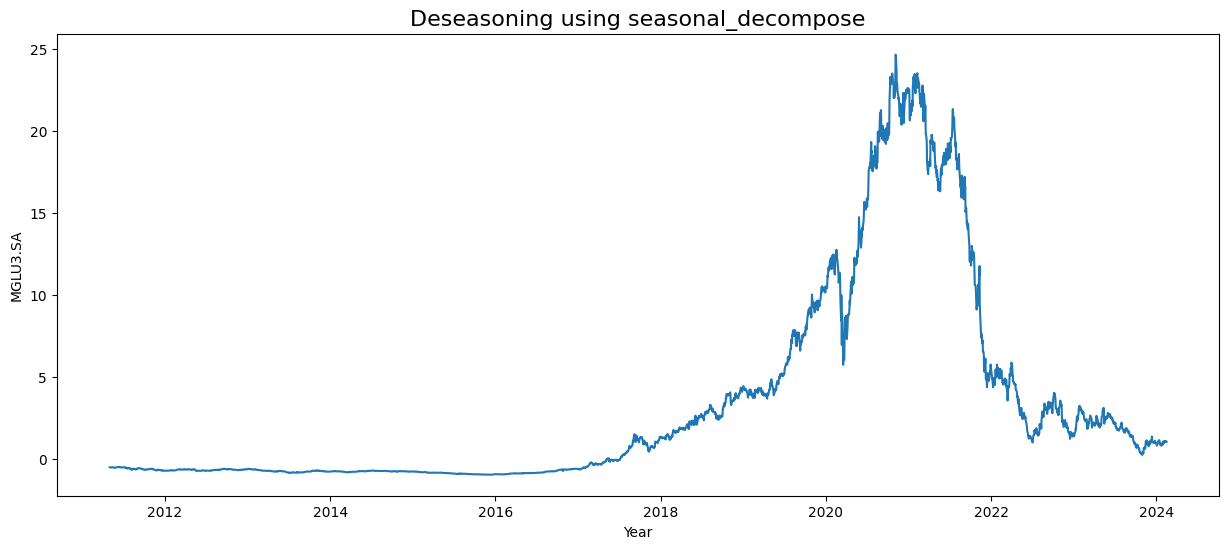

In [11]:
result_mul = seasonal_decompose(df["Close"], model='multiplicative', period=12, extrapolate_trend='freq')
deseason = df["Close"] - result_mul.seasonal
plt.figure(figsize=(15,6))
plt.plot(deseason)
plt.title('Deseasoning using seasonal_decompose', fontsize=16)
plt.xlabel('Year')
plt.ylabel(f'{asset}')
plt.show()

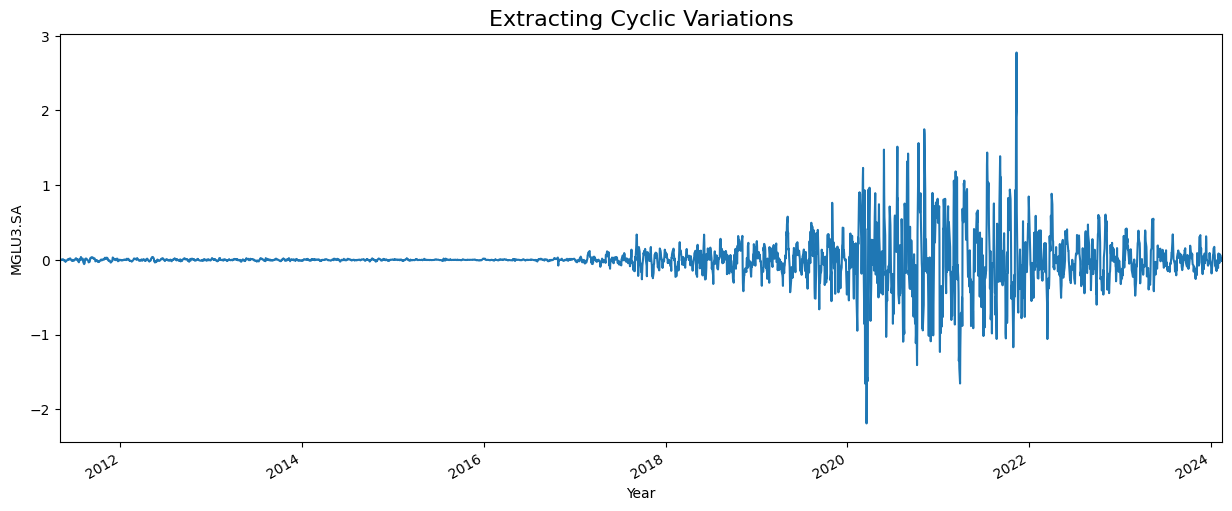

In [12]:
df_cycle, df_trend = hpfilter(df["Close"], lamb=1600)
df_cycle.plot(figsize=(15,6)).autoscale(axis='x',tight=True)
plt.title('Extracting Cyclic Variations', fontsize=16)
plt.xlabel('Year')
plt.ylabel(f'{asset}')
plt.show()

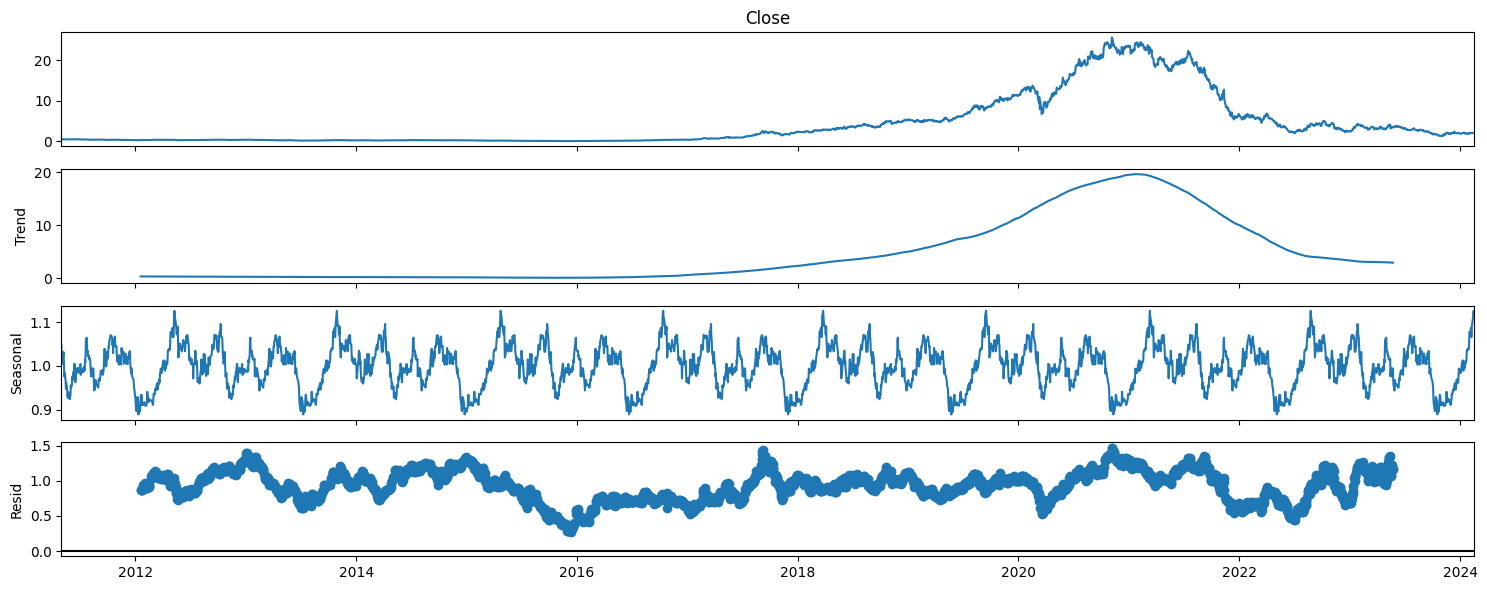

In [13]:
result = seasonal_decompose(df["Close"], period=365, model='mul')
result.plot();

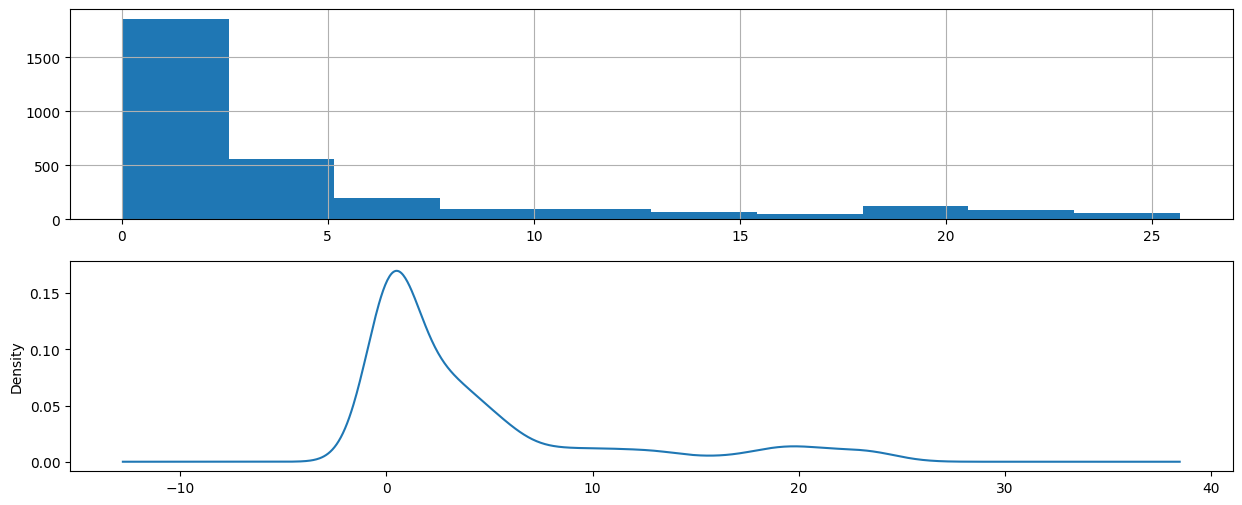

In [14]:
plt.figure(1, figsize=(15,6))
plt.subplot(211)
df["Close"].hist()
plt.subplot(212)
df["Close"].plot(kind='kde')
plt.show()

## Cálculo de Indicadores

## Cálculo de CandleSticks

## Previsões

In [15]:
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [16]:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [17]:
Augmented_Dickey_Fuller_Test_func(df["Close"],'Close')

Results of Dickey-Fuller Test for column: Close
Test Statistic                   -1.333682
p-value                           0.613625
No Lags Used                     28.000000
Number of Observations Used    3149.000000
Critical Value (1%)              -3.432428
Critical Value (5%)              -2.862458
Critical Value (10%)             -2.567259
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


In [18]:
X = df["Close"]
train, test = X[0:-90], X[-90:]

In [19]:

stepwise_model = auto_arima(train,start_p=1, start_q=1,
    max_p=100, max_q=100, seasonal=True,
    d=None, trace=True,error_action='ignore',suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-117.475, Time=1.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-108.914, Time=0.52 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-118.844, Time=1.23 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-118.529, Time=1.95 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-110.905, Time=0.51 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-117.329, Time=1.37 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-115.297, Time=1.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-120.834, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-119.319, Time=0.42 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-119.465, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-120.519, Time=0.24 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-117.467, Time=0.85 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 9.818 seconds


In [20]:
stepwise_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3088
Model:               SARIMAX(1, 1, 0)   Log Likelihood                  62.417
Date:                Sun, 18 Feb 2024   AIC                           -120.834
Time:                        21:46:13   BIC                           -108.764
Sample:                             0   HQIC                          -116.498
                               - 3088                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0621      0.006     -9.746      0.000      -0.075      -0.050
sigma2         0.0562      0.000    127.114      0.000       0.055       0.057
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             46403.35
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):            2594.48   Skew:                            -0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
forecast,conf_int = stepwise_model.predict(n_periods=90,return_conf_int=True)
forecast = pd.DataFrame(forecast,columns=['close_pred'])

In [22]:
df_conf = pd.DataFrame(conf_int,columns= ['Upper_bound','Lower_bound'])
df_conf["new_index"] = df.index[-90:]
df_conf = df_conf.set_index("new_index")

In [23]:
timeseries_evaluation_metrics_func(test, forecast)

Evaluation metric results:-
MSE is : 0.07599169079195829
MAE is : 0.24205184696685092
RMSE is : 0.275665904297137
MAPE is : 13.330601487799784
R2 is : -0.23618022973096764



In [24]:
forecast["new_index"] = df.index[-90:]
forecast = forecast.set_index("new_index")

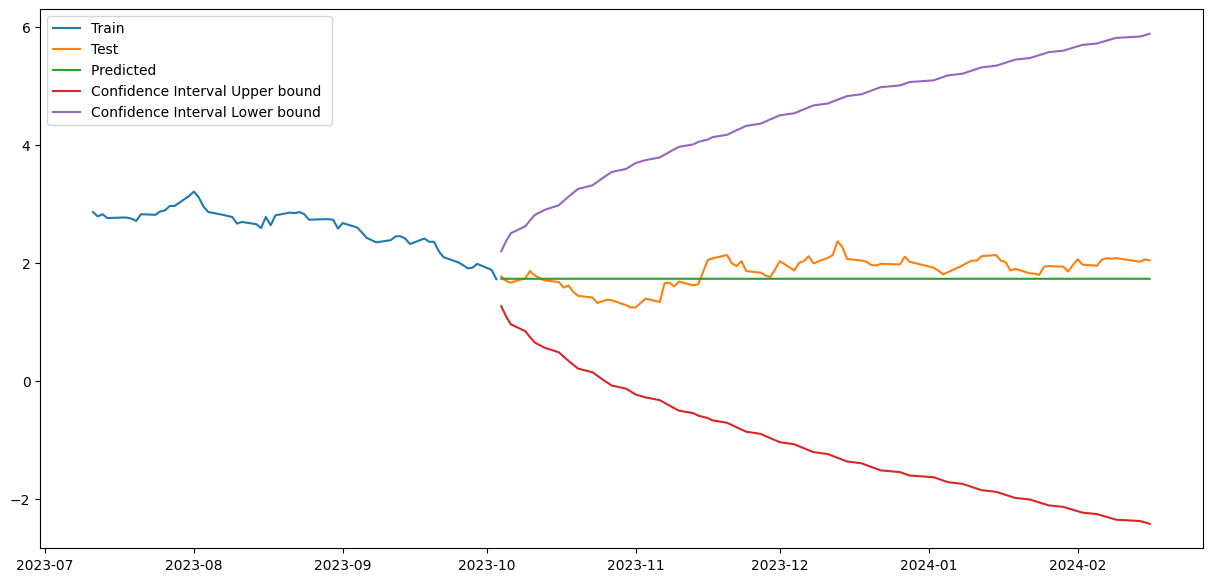

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [15,7]
plt.plot( train[-60:], label='Train ')
plt.plot(test, label='Test ')
plt.plot(forecast, label='Predicted ')
plt.plot(df_conf['Upper_bound'], label='Confidence Interval Upper bound ')
plt.plot(df_conf['Lower_bound'], label='Confidence Interval Lower bound ')
plt.legend(loc='best')
plt.show()

In [26]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon

    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])

        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

In [27]:
h = 90
predition_X = df.tail(h)
uni_data = df.drop(df.tail(h).index)

In [28]:
x_scaler = preprocessing.StandardScaler()
y_scaler = preprocessing.StandardScaler()
dataX = x_scaler.fit_transform(df)
dataY = y_scaler.fit_transform(df[['Trend']]) #y_scaler.fit_transform(np.array(df).reshape(-1, 1))

In [29]:
hist_window = 60
horizon = h

index_prev = data.loc[asset].index[-h:]
index_prev

from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
index_prev_oficial = pd.period_range(start=index_prev[-1], periods=h+1, freq=us_bd)[1:]


TRAIN_SPLIT = int((tamanho-h)*0.80)
x_train_multi, y_train_multi = custom_ts_multi_data_prep(
    dataX, dataY, 0, TRAIN_SPLIT, hist_window, horizon)
x_val_multi, y_val_multi= custom_ts_multi_data_prep(
    dataX, dataY, TRAIN_SPLIT, None, hist_window, horizon)

In [30]:
TRAIN_SPLIT

2470

In [31]:
print ('Single window of past history')
print(x_train_multi[0])
print ('\n Target horizon')
print (y_train_multi[0])

Single window of past history
[[-0.6053854  -0.60852302 -0.60378608 -0.60698355]
 [-0.60608465 -0.6081116  -0.60331077 -0.6070948 ]
 [-0.60524552 -0.60907142 -0.6027405  -0.60720567]
 [-0.60571174 -0.60939136 -0.6027405  -0.60731573]
 [-0.6062711  -0.6095285  -0.6042614  -0.60742395]
 [-0.60701708 -0.61012272 -0.6040713  -0.60752892]
 [-0.60701708 -0.61080826 -0.60378608 -0.60762909]
 [-0.60561843 -0.60897994 -0.6030732  -0.60772322]
 [-0.60552529 -0.6093457  -0.60331077 -0.6078103 ]
 [-0.60585162 -0.60943702 -0.60312068 -0.60788858]
 [-0.60585162 -0.60966564 -0.60259789 -0.60795554]
 [-0.60701708 -0.6105798  -0.60416626 -0.60800796]
 [-0.60841573 -0.61067112 -0.60535447 -0.60804192]
 [-0.60827585 -0.61135666 -0.60540211 -0.6080535 ]
 [-0.60776306 -0.611311   -0.6065903  -0.60803961]
 [-0.60804266 -0.61181374 -0.60640021 -0.60799793]
 [-0.60902167 -0.61126534 -0.6065903  -0.60792656]
 [-0.61121287 -0.61286504 -0.6081112  -0.60782424]
 [-0.60874206 -0.61240796 -0.60815869 -0.60769103]
 

In [32]:
BATCH_SIZE = 60
BUFFER_SIZE = 60

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [33]:
LSTM_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(60, input_shape=x_train_multi.shape[-2:],return_sequences=True),
    tf.keras.layers.LSTM(units=60,return_sequences=True),
    tf.keras.layers.LSTM(units=60),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=horizon),
])
LSTM_model.compile(optimizer='adam', loss='mse')

In [34]:
model_path = 'param.h5'

In [35]:
EVALUATION_INTERVAL = 100
EPOCHS = 150
history = LSTM_model.fit(train_data_multi, epochs=EPOCHS,steps_per_epoch=EVALUATION_INTERVAL,validation_data=val_data_multi, validation_steps=50,verbose =1,
                              callbacks =[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'),tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

Epoch 1/150
100/100 [==============================] - 21s 147ms/step - loss: 0.5064 - val_loss: 1.0215
Epoch 2/150
100/100 [==============================] - 13s 134ms/step - loss: 0.3215 - val_loss: 0.7340
Epoch 3/150
100/100 [==============================] - 13s 133ms/step - loss: 0.1758 - val_loss: 0.2399
Epoch 4/150
100/100 [==============================] - 13s 133ms/step - loss: 0.1423 - val_loss: 0.0955
Epoch 5/150
100/100 [==============================] - 13s 134ms/step - loss: 0.2756 - val_loss: 0.8692
Epoch 6/150
100/100 [==============================] - 14s 140ms/step - loss: 0.1482 - val_loss: 0.8807
Epoch 7/150
100/100 [==============================] - 13s 133ms/step - loss: 0.1721 - val_loss: 0.3003
Epoch 8/150
100/100 [==============================] - 13s 134ms/step - loss: 0.0890 - val_loss: 0.2385
Epoch 9/150
100/100 [==============================] - 13s 133ms/step - loss: 0.0861 - val_loss: 0.3788
Epoch 10/150
100/100 [==============================] - 15s 153m

In [36]:
# Recreate the exact same model, including its weights and the optimizer
Trained_model = tf.keras.models.load_model(model_path)

In [37]:
# Show the model architecture
Trained_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 60)            15600     
                                                                 
 lstm_1 (LSTM)               (None, 60, 60)            29040     
                                                                 
 lstm_2 (LSTM)               (None, 60)                29040     
                                                                 
 dropout (Dropout)           (None, 60)                0         
                                                                 
 dense (Dense)               (None, 90)                5490      
                                                                 
Total params: 79170 (309.26 KB)
Trainable params: 79170 (309.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


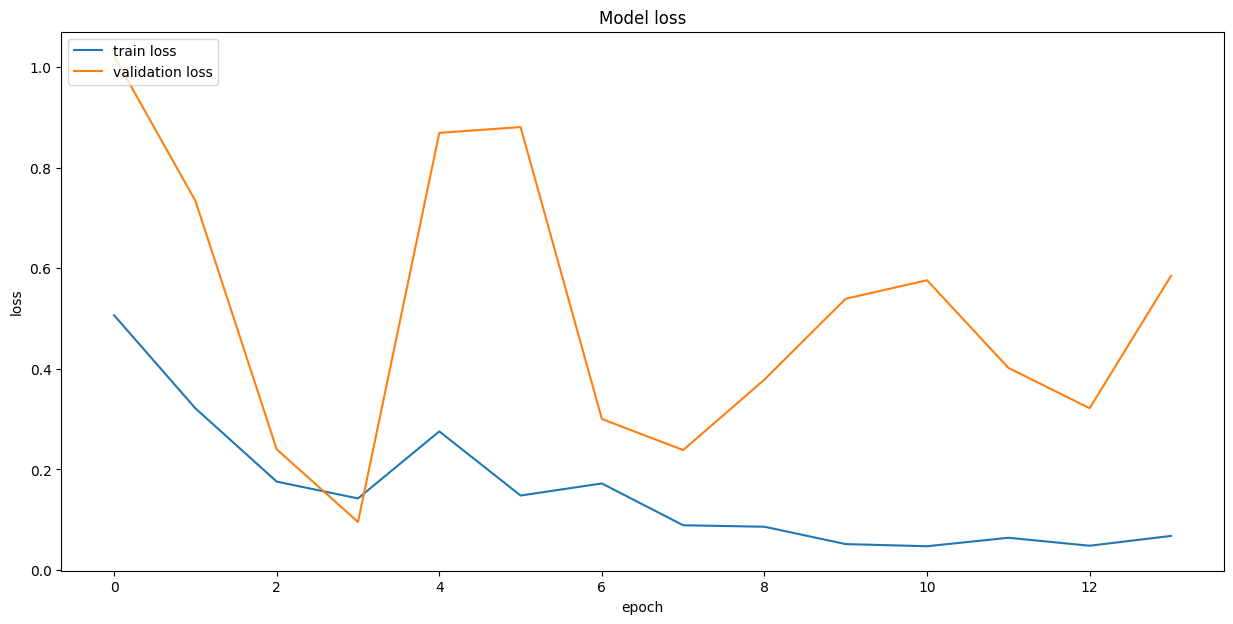

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [39]:
data_val = x_scaler.fit_transform(uni_data.tail(hist_window))
val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])
Predicted_results = Trained_model.predict(val_rescaled)
Predicted_results

1/1 [==============================] - 3s 3s/step


array([[-0.66941565, -0.6249528 , -0.72933155, -0.667526  , -0.6987229 ,
        -0.68827677, -0.7086781 , -0.7560523 , -0.7074594 , -0.652582  ,
        -0.64910764, -0.6780697 , -0.65534186, -0.65029615, -0.7242002 ,
        -0.6496419 , -0.61160564, -0.69232225, -0.6804358 , -0.64084244,
        -0.7010646 , -0.5921849 , -0.63058877, -0.6999329 , -0.5873531 ,
        -0.62340075, -0.6628067 , -0.66755974, -0.68832034, -0.6327717 ,
        -0.6316608 , -0.69089705, -0.64560205, -0.68508697, -0.70219964,
        -0.65816635, -0.62814337, -0.59983945, -0.6620805 , -0.6152053 ,
        -0.58562636, -0.648849  , -0.6387785 , -0.6683676 , -0.68869275,
        -0.64962155, -0.7376195 , -0.6133496 , -0.8013257 , -0.6442494 ,
        -0.63291925, -0.70093036, -0.7022286 , -0.6617625 , -0.6939346 ,
        -0.5779951 , -0.66259295, -0.6410847 , -0.656658  , -0.69801277,
        -0.7363069 , -0.68360853, -0.57618284, -0.5954705 , -0.67945445,
        -0.6797455 , -0.6653748 , -0.5972575 , -0.6

In [40]:
df2 = predition_X
df2_cycle,df2_trend = hpfilter(df2["Close"], lamb=1600)
df2["Trend"] = df2_trend
data_pred = x_scaler.fit_transform(df2.tail(hist_window))
pred_rescaled = data_pred.reshape(1, data_pred.shape[0], data_pred.shape[1])
Predicted_results_oficial = Trained_model.predict(pred_rescaled)
Predicted_results_oficial_Inv_trans = y_scaler.inverse_transform(Predicted_results_oficial.reshape(-1,1))
Predicted_results_oficial_Inv_trans = pd.DataFrame(Predicted_results_oficial_Inv_trans, columns=['Trend'], index=index_prev_oficial)
Predicted_results_oficial_Inv_trans_cycle,Predicted_results_oficial_Inv_trans_trend = hpfilter(Predicted_results_oficial_Inv_trans, lamb=1600)
ajuste2 = Predicted_results_oficial_Inv_trans_trend[0]-df_close.tail(h+1)[-1]
Predicted_results_oficial_Inv_trans = Predicted_results_oficial_Inv_trans-ajuste2
Predicted_results_oficial_Inv_trans_trend = Predicted_results_oficial_Inv_trans_trend-ajuste2

1/1 [==============================] - 0s 44ms/step


In [41]:
Predicted_results_Inv_trans = y_scaler.inverse_transform(Predicted_results.reshape(-1,1))
Predicted_results_Inv_trans = pd.DataFrame(Predicted_results_Inv_trans, columns=['Trend'], index=index_prev)
Predicted_results_Inv_trans_cycle,Predicted_results_Inv_trans_trend = hpfilter(Predicted_results_Inv_trans, lamb=1600)
ajuste = Predicted_results_Inv_trans_trend[0]-df_close.tail(h+1)[0]
Predicted_results_Inv_trans_trend = Predicted_results_Inv_trans_trend-ajuste
Predicted_results_Inv_trans = Predicted_results_Inv_trans-ajuste

In [42]:
validate = pd.DataFrame(df_close.tail(h), columns=['Close'], index=index_prev)

In [43]:
timeseries_evaluation_metrics_func(validate,Predicted_results_Inv_trans_trend)

Evaluation metric results:-
MSE is : 0.06039557635731956
MAE is : 0.18288112626277675
RMSE is : 0.2457551146107026
MAPE is : 12.858679352298234
R2 is : 0.017526565364614055



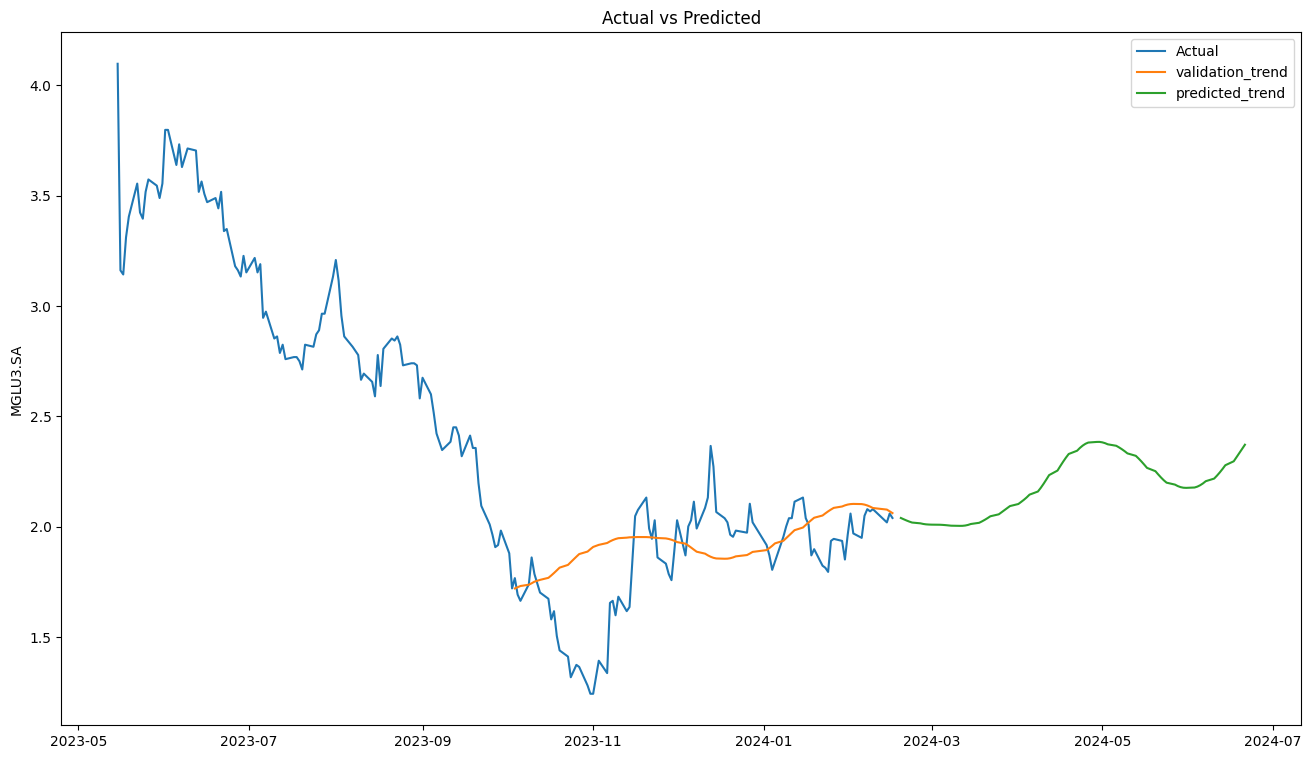

In [44]:
plt.plot(df_close.tail(h+100))
#plt.plot( Predicted_results_Inv_trans)
#plt.plot( Predicted_results_oficial_Inv_trans)
plt.plot(Predicted_results_Inv_trans_trend)
plt.plot(Predicted_results_oficial_Inv_trans_trend)
plt
plt.title("Actual vs Predicted")
plt.ylabel(f'{asset}')
plt.legend(('Actual','validation_trend','predicted_trend'))
plt.show()